In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import pathlib
import pysam
import pyfaidx
import warnings
import re
import argparse
import sys
from tqdm import tqdm 
tqdm.pandas()
warnings.filterwarnings("ignore")

path_to_all_fa = "/media/hieunguyen/GSHD_HN01/storage/resources/hg19"
paneldf = pd.read_excel("../panel_design/All_panel_designs_20250601.xlsx", sheet_name = "Lung_panel_version_1.1")

genome_version = "hg19"

##### specify output_type
# output_type = "connor"
output_type = "raw"

##### specify UMT DISTANCE THRESHOLD.
umt_distance = 1
# umt_distance = 0

maindir = "/media/hieunguyen/HNHD01/outdir/ampliconSeq/from_VM/20250601"
path_to_main_output = os.path.join(maindir, "data_analysis", f"UMT_DISTANCE_{umt_distance}")

path_to_01_output = os.path.join(path_to_main_output, output_type, "01_output")
os.system(f"mkdir -p {path_to_01_output}")

def get_refseq(path_to_all_fa, chrom, start, end):
        refseq = pyfaidx.Fasta(os.path.join(path_to_all_fa, "{}.fa".format(chrom)))
        return(str.upper(refseq.get_seq(name = "{}".format(chrom), start = start, end = end).seq))

##### get list of all real cpg for this panel
cpgdf = pd.DataFrame()
for region in paneldf[genome_version].unique():
    region_name = paneldf[paneldf[genome_version] == region]["Amplicon"].values[0]
    chrom = region.split(":")[0].replace("chr", "")
    start = int(region.split(":")[1].split("-")[0])
    end = int(region.split(":")[1].split("-")[1])
    refseq = pyfaidx.Fasta(os.path.join(path_to_all_fa, "chr{}.fa".format(chrom)))
    refseq_at_region = str.upper(refseq.get_seq(name = "chr{}".format(chrom), start = start, end = end).seq)

    all_cpg_in_cluster = [m.start(0) for m in re.finditer("CG", refseq_at_region)]
    cpg_coords = [f"chr{chrom}:{item + start}-{item + start + 1}" for item in all_cpg_in_cluster]

    tmp_cpgdf = pd.DataFrame(data = cpg_coords, columns = ["CpG"])
    tmp_cpgdf["region"] = region
    tmp_cpgdf["region_name"] = region_name
    cpgdf = pd.concat([cpgdf, tmp_cpgdf], axis = 0)

cpgdf = cpgdf[["region", "CpG", "region_name"]]

covdir = os.path.join(maindir, f"UMT_DISTANCE_{umt_distance}", "BISMARK_COV")

# fetch .connor.bam files only, UMI pre-processed files
if output_type == "connor":
    all_cov_files = [item for item in pathlib.Path(covdir).glob("*.cov") if "connor" in item.name]
if output_type == "raw":
    all_cov_files = [item for item in pathlib.Path(covdir).glob("*.cov") if "CutAdapt" in item.name]

print(f"Number of input cov file in this folder: {len(all_cov_files)}")
metadata = pd.DataFrame(data = [str(item) for item in all_cov_files], columns = ["path"])
metadata["SampleID"] = metadata["path"].apply(lambda x: x.split("/")[-1].split(".connor")[0].split("_")[0].split("-")[1])
metadata["Sample"] = metadata["SampleID"].apply(lambda x: x.replace("TM", "") if "PANEL" in x else f"S{x.split('S')[1]}")
metadata["amplicon"] = metadata[["SampleID", "Sample"]].apply(lambda x: x[0].replace("TM", "").replace(x[1], ""), axis = 1)
metadata["BAM"] = metadata["path"].apply(lambda x: x.replace("bedGraph.gz.bismark.zero.cov", "bam").replace("BISMARK_COV", "BISMARK_ALIGNMENT"))

def is_non_zero_file(fpath):  
    import subprocess
    output = subprocess.run(f"cat {fpath} | wc -l", shell=True, capture_output=True, text=True)
    return int(output.stdout.strip())

proc_cov_path = []
for input_cov_file in metadata.path.to_list():
    sampleid = input_cov_file.split("/")[-1].split(".connor")[0]
    if os.path.isfile(os.path.join(path_to_01_output, f"{sampleid}_cov.xlsx")) == False:
        if is_non_zero_file(input_cov_file) != 0:
            covdf = pd.read_csv(input_cov_file, header = None, sep = "\t")
            covdf.columns = ["chrom", "start", "end", "meth_density", "countC", "countT"]
            covdf = covdf[covdf["chrom"].isin(["chrX", "chrY", "chrMT"]) == False]
            covdf = covdf[covdf["chrom"].str.contains("chrUn") == False]
            covdf = covdf[covdf["chrom"].str.contains("_") == False]
            covdf["seq"] = covdf[["chrom", "start"]].progress_apply(lambda x: get_refseq(path_to_all_fa= path_to_all_fa, 
                                                                    chrom = x[0], start = x[1], end = x[1] + 1), axis = 1)
            covdf["strand"] = covdf["seq"].apply(lambda x: "+" if x != "CG" else "-")
            covdf_raw = covdf.copy()
            covdf["start"] = covdf[["seq", "start"]].apply(lambda x: x[1] + 1 if x[0] != "CG" else x[1], axis = 1)

            covdf["chrom"] = covdf["chrom"].apply(lambda x: str(x))
            covdf["CpG"] = covdf[["chrom", "start"]].apply(lambda x: f"{str(x[0])}:{x[1]}-{x[1] + 1}", axis = 1)
            covdf["check_context"] = covdf["CpG"].apply(lambda x: "CpG_context" if x in cpgdf["CpG"].values else "False")
            covdf["amplicon"] = covdf["CpG"].apply(lambda x: cpgdf[cpgdf["CpG"] == x]["region_name"].values[0] if x in cpgdf["CpG"].values else "NA")
        else:
            covdf = pd.DataFrame(columns = ["chrom", "start", "end", "meth_density", "countC", "countT", "seq", "strand", "CpG", "check_context", "amplicon"])
        covdf.to_excel(os.path.join(path_to_01_output, f"{sampleid}_cov.xlsx"), index = False)
        proc_cov_path.append(os.path.join(path_to_01_output, f"{sampleid}_cov.xlsx"))
    else:
        proc_cov_path.append(os.path.join(path_to_01_output, f"{sampleid}_cov.xlsx"))
metadata["proc_cov_path"] = proc_cov_path

Number of input cov file in this folder: 100


# Plot: S1 --> S5 and methylation density of all captured CpG in the amplicon region

ValueError: Excel file format cannot be determined, you must specify an engine manually.

<Figure size 1200x600 with 0 Axes>

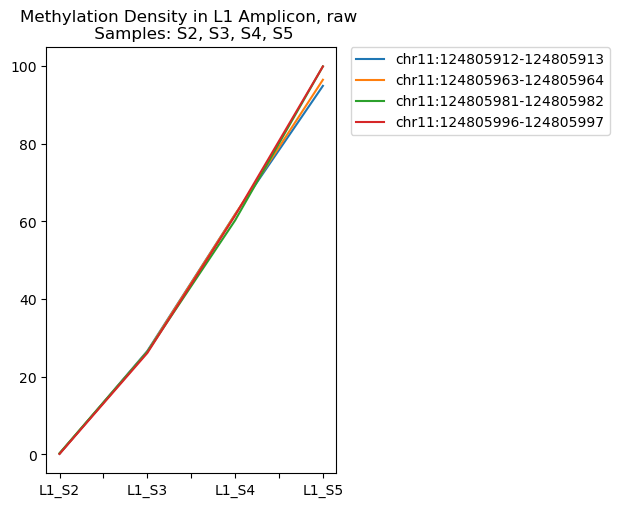

<Figure size 1200x600 with 0 Axes>

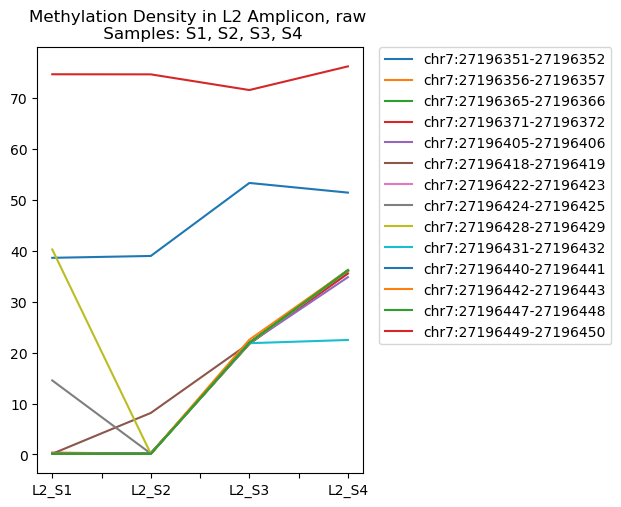

<Figure size 1200x600 with 0 Axes>

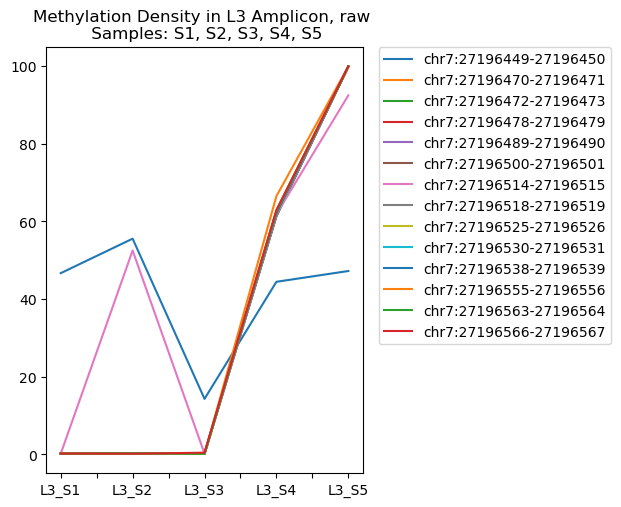

<Figure size 1200x600 with 0 Axes>

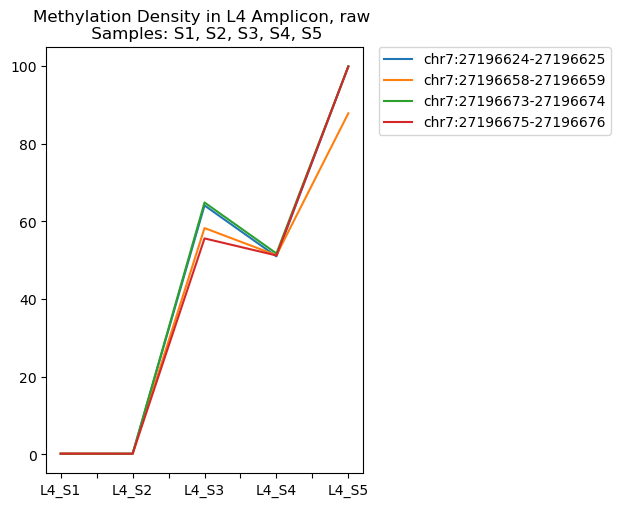

<Figure size 1200x600 with 0 Axes>

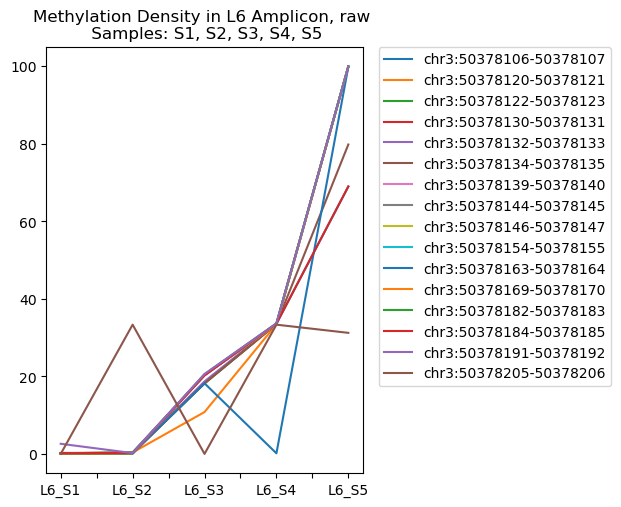

<Figure size 1200x600 with 0 Axes>

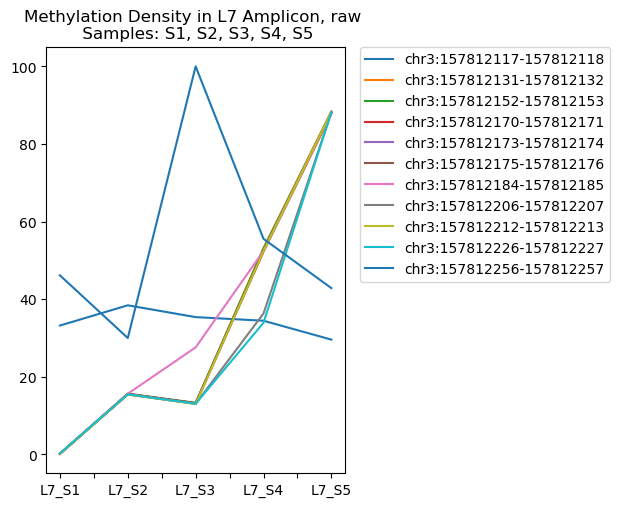

<Figure size 1200x600 with 0 Axes>

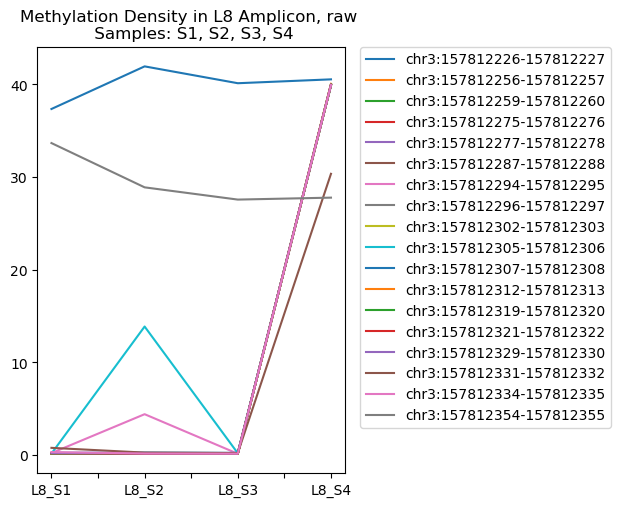

<Figure size 1200x600 with 0 Axes>

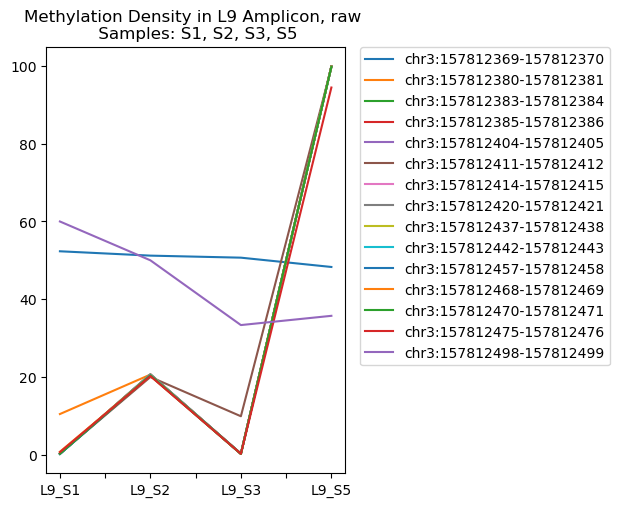

<Figure size 1200x600 with 0 Axes>

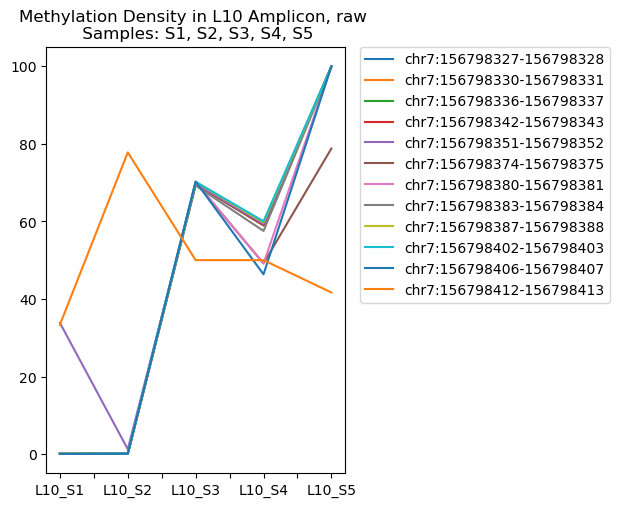

<Figure size 1200x600 with 0 Axes>

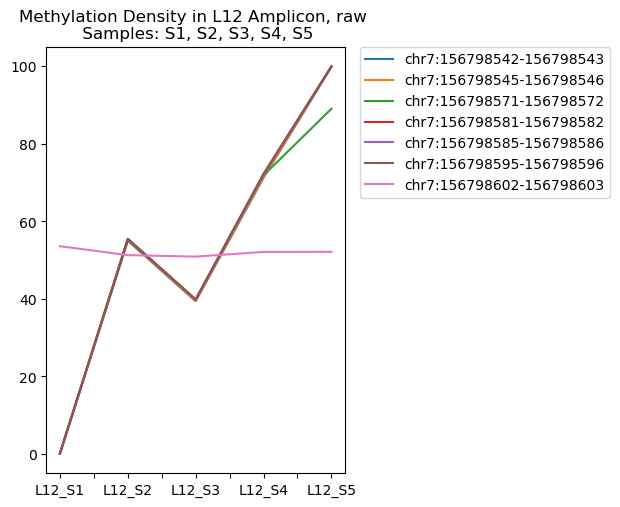

In [2]:
os.system(f"mkdir -p {os.path.join(path_to_01_output, 'S1_to_S5_in_amplicons')}")

for amplicon in paneldf["Amplicon"].unique():
# for amplicon in ["L11"]:
    tmp_metadata = metadata[metadata["amplicon"] == amplicon].sort_values(by = "Sample")
    covdf = pd.DataFrame(data = cpgdf[cpgdf["region_name"] == amplicon]["CpG"].values, columns = ["CpG"])
        
    if tmp_metadata.shape[0] > 1:
        for i in range(tmp_metadata.shape[0]):
            p = tmp_metadata.iloc[i]["proc_cov_path"]
            sample  = tmp_metadata.iloc[i]["Sample"]
            tmp_covdf = pd.read_excel(p)[["CpG", "meth_density"]]
            tmp_covdf.columns = ["CpG", f"{amplicon}_{sample}"]
            covdf = covdf.merge(tmp_covdf, right_on = "CpG", left_on = "CpG")
        if covdf.shape[0] > 1:
            plt.figure(figsize=(12, 6))
            covdf.set_index("CpG").T.plot.line()
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            plt.tight_layout()
            plt.title(f"Methylation Density in {amplicon} Amplicon, {output_type} \n Samples: {', '.join(tmp_metadata['Sample'].unique())}")
            plt.savefig(os.path.join(path_to_01_output, "S1_to_S5_in_amplicons", f"{amplicon}_methylation_density.png"), dpi=300, bbox_inches='tight')


# Count reads in regions

In [ ]:
all_BAMs = metadata["BAM"].unique().tolist()
for file in all_BAMs:
    os.system(f"samtools sort {file} -o {file.replace('.bam', '.sorted.bam')}")
    os.system(f"samtools index {file.replace('.bam', '.sorted.bam')}")


In [ ]:
###### count on/off target reads
def count_read_in_region(bam_path, region, chr_mode = False):
    all_reads = []
    bamfile = pysam.AlignmentFile(bam_path, "rb")
    if chr_mode:
        region = f"chr{region}"
    fetched_obj = bamfile.fetch(region = region)
    for read in fetched_obj:
        all_reads.append(read)
    return(len(all_reads))

rerun = True
if os.path.isfile(os.path.join(path_to_01_output, f"read_count_in_region.xlsx")) == False or rerun == True:
    tqdm.pandas()
    metadata["num_total_reads"] = metadata["BAM"].progress_apply(lambda x: int(pysam.samtools.view("-c", x.replace(".bam", ".sorted.bam"), catch_stdout=True)))

    for bam_region in tqdm(paneldf[genome_version].unique()):
        region_name = paneldf[paneldf[genome_version] == bam_region]["Amplicon"].values[0]
        metadata[f"count_{region_name}"] = metadata["BAM"].apply(lambda x: count_read_in_region(x.replace(".bam", ".sorted.bam"), bam_region))
        metadata[f"pct_{region_name}"] = metadata[f"count_{region_name}"] / metadata["num_total_reads"] * 100
        
    metadata.to_excel(os.path.join(path_to_01_output, f"read_count_in_region.xlsx"), index = False)
else:
    print("File already exists, skip counting reads in regions. Reading existing data... ")
    metadata = pd.read_excel(os.path.join(path_to_01_output, f"read_count_in_region.xlsx"))

plotdf = metadata.sort_values(by = "amplicon")[[item for item in metadata.columns if "pct" in item] + ["SampleID"]].sort_values(by = "SampleID").set_index("SampleID")
plt.figure(figsize=(35, 20))
plt.tight_layout()
sns.heatmap(plotdf,cmap="YlGnBu", fmt=".2f", annot=True, linewidths=.5, linecolor='black', cbar_kws={"label": "Percentage of reads in region (%)"})
plt.savefig(os.path.join(path_to_01_output, "percentage_of_reads_in_regions.png"), dpi=300, bbox_inches='tight')

In [ ]:
plotdf = metadata.sort_values(by = "amplicon")[[item for item in metadata.columns if "count" in item] + ["SampleID"]].sort_values(by = "SampleID").set_index("SampleID")
plt.figure(figsize=(20, 20))
plt.tight_layout()
sns.heatmap(plotdf,cmap="YlGnBu", fmt=".2f", annot=True, linewidths=.5, linecolor='black', cbar_kws={"label": "Percentage of reads in region (%)"})
plt.savefig(os.path.join(path_to_01_output, "number_of_reads_in_regions.png"), dpi=300, bbox_inches='tight')

In [ ]:
metadata

In [ ]:
methdf = pd.DataFrame()
for sampleid in tqdm(metadata.SampleID.unique()):
    covdf = pd.read_excel(metadata[metadata["SampleID"] == sampleid]["proc_cov_path"].values[0])
    covdf[covdf["check_context"] == "CpG_context"]
    tmpdf = pd.DataFrame(data = [sampleid], columns = ["SampleID"])
    for amplicon in paneldf["Amplicon"].unique():
        tmpdf[amplicon] = covdf[covdf["amplicon"] == amplicon]["meth_density"].mean()
    tmpdf.fillna(0, inplace = True)
    methdf = pd.concat([methdf, tmpdf], axis = 0)
methdf.sort_values(by = "SampleID", inplace = True)


In [ ]:
plt.figure(figsize=(35, 20))
plt.tight_layout()
sns.heatmap(methdf.set_index("SampleID"),cmap="YlGnBu", fmt=".2f", annot=True, linewidths=.5, linecolor='black', cbar_kws={"label": "Average amplicon methylation density (%)"})
plt.savefig(os.path.join(path_to_01_output, "amplicon_methylation_density_heatmap.png"), dpi=300, bbox_inches='tight')

In [ ]:
cpg_count_amplicon = cpgdf.groupby("region_name")["CpG"].count().reset_index()
cpg_count_amplicon

In [ ]:
methdf = pd.DataFrame()
for sampleid in tqdm(metadata.SampleID.unique()):
    covdf = pd.read_excel(metadata[metadata["SampleID"] == sampleid]["proc_cov_path"].values[0])
    covdf[covdf["check_context"] == "CpG_context"]
    tmpdf = pd.DataFrame(data = [sampleid], columns = ["SampleID"])
    for amplicon in paneldf["Amplicon"].unique():
        tmpdf[amplicon] = 100 * len(covdf[covdf["amplicon"] == amplicon].CpG.unique())/ cpg_count_amplicon[cpg_count_amplicon["region_name"] == amplicon]["CpG"].values[0]
    tmpdf.fillna(0, inplace = True)
    methdf = pd.concat([methdf, tmpdf], axis = 0)
methdf.sort_values(by = "SampleID", inplace = True)

In [ ]:
plt.figure(figsize=(35, 20))
plt.tight_layout()
sns.heatmap(methdf.set_index("SampleID"),cmap="YlGnBu", fmt=".2f", annot=True, linewidths=.5, linecolor='black', cbar_kws={"label": "Average amplicon methylation density (%)"})
plt.savefig(os.path.join(path_to_01_output, "percentage_of_captured_cpg_in_amplicons.png"), dpi=300, bbox_inches='tight')